# Import Library

In [ ]:
!pip install openpyxl

In [131]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras
from keras.utils.vis_utils import plot_model

import os
import warnings
warnings.filterwarnings("ignore")
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.signal import savgol_filter
from scipy.ndimage.interpolation import shift

# Load Data

In [ ]:
data_train = pd.read_excel('../input/heat-def/DVF5000_SPD_Spectrum1_Steel.xlsx', sheet_name = 'Sheet1' )    
data_train2 = pd.read_excel('../input/thermal-disp23-spindle/DVF5000_SPD_Spectrum2_Steel.xlsx', sheet_name = 'Sheet1' )    
data_train3 = data_train2
#data_train3 = pd.read_excel('../input/thermal-disp23-spindle/DVF5000_SPD_Spectrum3_Steel.xlsx', sheet_name = 'Sheet1' )    

In [2]:
data_train = pd.read_excel('DVF5000_SPD_Spectrum1_Steel.xlsx', sheet_name = 'Sheet1' )    
data_train2 = pd.read_excel('DVF5000_SPD_Spectrum2_Steel.xlsx', sheet_name = 'Sheet1' )    
data_train3 = pd.read_excel('DVF5000_SPD_Spectrum3_Steel.xlsx', sheet_name = 'Sheet1' )   

# Preprocessing

## 불필요한 column 제거

In [3]:
data_train = data_train.drop(columns = ['SCAN', 'Day', 'Time'])
data_train2 = data_train2.drop(columns = ['SCAN', 'Day', 'Time'])
data_train3 = data_train3.drop(columns = ['SCAN', 'Day', 'Time'])

In [4]:
Sensor_index = 2 
if Sensor_index == 2:
    pd_raw_X = data_train[['H1', 'S2', 'S3', 'S4', 'S5', 'S6', 'X_Motor', 'Y_Motor', 'Z_Motor',
        'SPD_Motor', 'X_Servo', 'X_Screw_BRG',
        'Y_Servo', 'Y_Screw_BRG', 'Z_Screw_BRG', 'Column_Rear',
        'Saddle_Rear', 'Bed_Mid', 'C_Axis_Gear', 'C_Axis_BRG', 'Air_Upper',
        'Air_Lower', 'Machine_Room_Air', 'Cooler_Outler_Supply',
        'Cooler_Inlet_Return']]
    pd_raw_X2 = data_train2[['H1', 'S2', 'S3', 'S4', 'S5', 'S6', 'X_Motor', 'Y_Motor', 'Z_Motor',
        'SPD_Motor', 'X_Servo', 'X_Screw_BRG',
        'Y_Servo', 'Y_Screw_BRG', 'Z_Screw_BRG', 'Column_Rear',
        'Saddle_Rear', 'Bed_Mid', 'C_Axis_Gear', 'C_Axis_BRG', 'Air_Upper',
        'Air_Lower', 'Machine_Room_Air', 'Cooler_Outler_Supply',
        'Cooler_Inlet_Return']]
    pd_raw_X3 = data_train3[['H1', 'S2', 'S3', 'S4', 'S5', 'S6', 'X_Motor', 'Y_Motor', 'Z_Motor',
        'SPD_Motor', 'X_Servo', 'X_Screw_BRG',
        'Y_Servo', 'Y_Screw_BRG', 'Z_Screw_BRG', 'Column_Rear',
        'Saddle_Rear', 'Bed_Mid', 'C_Axis_Gear', 'C_Axis_BRG', 'Air_Upper',
        'Air_Lower', 'Machine_Room_Air', 'Cooler_Outler_Supply',
        'Cooler_Inlet_Return']]
elif Sensor_index == 1:
    pd_raw_X = data_train[['H1', 'S2', 'S3', 'S4', 'S5', 'S6']]
    pd_raw_X2 = data_train2[['H1', 'S2', 'S3', 'S4', 'S5', 'S6']]
    pd_raw_X3 = data_train3[['H1', 'S2', 'S3', 'S4', 'S5', 'S6']]
## Spindle RPM은 온도 변수가 아니어서 제거, Z_Servo도 Axis Shift로 인한 열변형이므로 제거

In [5]:
pd_raw_Y = data_train.filter(like = 'DISP')
pd_raw_Y2 = data_train2.filter(like = 'DISP')
pd_raw_Y3 = data_train3.filter(like = 'DISP')

In [6]:
## Error data 제거를 위한 Slicing
Slice_value = 300
pd_raw_X = pd_raw_X.iloc[Slice_value:-Slice_value,:]
pd_raw_X2 = pd_raw_X2.iloc[Slice_value:-Slice_value,:]
pd_raw_X3 = pd_raw_X3.iloc[Slice_value:-Slice_value,:]
pd_raw_Y = pd_raw_Y.iloc[Slice_value:-Slice_value,:]
pd_raw_Y2 = pd_raw_Y2.iloc[Slice_value:-Slice_value,:]
pd_raw_Y3 = pd_raw_Y3.iloc[Slice_value:-Slice_value,:]

In [36]:
#Boolean 집합
Smoothing_Curve = 0 ##Moving Average 적용 = 1, 미적용 = 0
Time_Split_Boolean = 0 ##Sampling rate 변경 적용 = 1, 미적용 = 0
Scale_Boolean = 1 ##Scaler 적용 = 1, 미적용 = 0
TD_Boolean = 1 ## Timedistributed 적용 = 1, 미적용 = 0
Cv_Boolean = 1 ## Conv1D 적용 = 1, 미적용 = 0
Savgol_Boolean = 1

In [37]:
#raise SystemExit("Exit from script")

#sys.exit("Exit from script")

## Moving Average

In [38]:
##Smoothing_Curve 0 = None
##Smoothing_Curve 1 = Moving Average 적용 (Default)
if Smoothing_Curve == 1:
    
    Window_Size = 59 ##하기의 M에 해당, 홀수로 설정하여야 계산 용이
    
    def Moving_Average(Target_Dataframe,Window_Size): ##Target Array = Dataframe 형태
        Window_array = np.ones(Window_Size)*float(1/Window_Size)
        Smooth_Sensor = np.zeros((Target_Dataframe.shape[0]-Window_Size+1,Target_Dataframe.shape[1]))
        for i in range(Target_Dataframe.shape[1]):
            ##Target_Array.iloc[:,i] = savgol_filter(Target_Array.iloc[:,i],59,3) Window안의 회귀모형 FIlter, 성능은 좋으나 Computation 과하게 소모, Length 확인 필요
            y_smooth = np.convolve(Target_Dataframe.iloc[:,i],Window_array) ## N + M - 1개 array 반환
            y_smooth = shift(y_smooth,Window_Size-1) ## N + M - 1개 array에서 뒤의 (M-1)개 절단
            y_smooth = y_smooth[2*(Window_Size-1):] ## N + M - 1개 array에서 앞쪽 (M-1)개 절단, total 2*(M-1)개 절단
            Smooth_Sensor[:,i] = y_smooth ## Sensor 길이 N에서 N-M+1개로 바뀜
        Smooth_Sensor = pd.DataFrame(Smooth_Sensor, columns = Target_Dataframe.columns)    
        return Smooth_Sensor

    pd_raw_X = Moving_Average(pd_raw_X,Window_Size)
    pd_raw_Y = Moving_Average(pd_raw_Y,Window_Size)
    pd_raw_X2 = Moving_Average(pd_raw_X2,Window_Size)
    pd_raw_Y2 = Moving_Average(pd_raw_Y2,Window_Size)
    pd_raw_X3 = Moving_Average(pd_raw_X3,Window_Size)
    pd_raw_Y3 = Moving_Average(pd_raw_Y3,Window_Size)

## Savgol_filter

In [39]:
if Savgol_Boolean == 1:   
    for i in range(pd_raw_Y.shape[1]):
        pd_raw_Y.iloc[:,i] = savgol_filter(pd_raw_Y.iloc[:,i], 1801, 5)
        pd_raw_Y2.iloc[:,i] = savgol_filter(pd_raw_Y2.iloc[:,i], 1801, 5)
        pd_raw_Y3.iloc[:,i] = savgol_filter(pd_raw_Y3.iloc[:,i], 1801, 5)
    for i in range(pd_raw_X.shape[1]):
        pd_raw_X.iloc[:,i] = savgol_filter(pd_raw_X.iloc[:,i], 1801, 5)
        pd_raw_X2.iloc[:,i] = savgol_filter(pd_raw_X2.iloc[:,i], 1801, 5)
        pd_raw_X3.iloc[:,i] = savgol_filter(pd_raw_X3.iloc[:,i], 1801, 5)

## Time_Split

In [40]:
#Sampling 단위 변경
if Time_Split_Boolean == 1:
    
    time_stride = 60
    
    def Time_split_Data(Dataframe,time_stride):
        Quote , remainder = divmod(Dataframe.shape[0],time_stride)
        split_data = np.zeros((Quote,Dataframe.shape[1]))
        for i in range(Quote):
            split_data[i,:] = Dataframe.iloc[time_stride*i,:]
        return pd.DataFrame(split_data) 
    
    pd_raw_X = Time_split_Data(pd_raw_X,time_stride)
    pd_raw_Y = Time_split_Data(pd_raw_Y,time_stride)
    pd_raw_X2 = Time_split_Data(pd_raw_X2,time_stride)
    pd_raw_Y2 = Time_split_Data(pd_raw_Y2,time_stride)
    pd_raw_X3 = Time_split_Data(pd_raw_X3,time_stride)
    pd_raw_Y3 = Time_split_Data(pd_raw_Y3,time_stride)

## Scaling

In [41]:
#Scaler 적용
if Scale_Boolean == 1:
    #X_Scaler = MinMaxScaler()
    #Y_Scaler = MinMaxScaler()
    X_Scaler = StandardScaler()
    Y_Scaler = StandardScaler()
    X2_Scaler = StandardScaler()
    Y2_Scaler = StandardScaler()
    pd_raw_X = pd.DataFrame( X_Scaler.fit_transform(pd_raw_X) )
    pd_raw_Y = pd.DataFrame( Y_Scaler.fit_transform(pd_raw_Y) )
    pd_raw_X2 = pd.DataFrame( X2_Scaler.fit_transform(pd_raw_X2) )
    pd_raw_Y2 = pd.DataFrame( Y2_Scaler.fit_transform(pd_raw_Y2) )
    pd_raw_X3 = pd.DataFrame( X_Scaler.fit_transform(pd_raw_X3) )
    pd_raw_Y3 = pd.DataFrame( Y_Scaler.fit_transform(pd_raw_Y3) )

## Sliding Window(Batch 형태로 변환)

In [142]:
def sliding_window(X, Y, n_steps, time, stride = 1, time_distributed = 0):
        
    # 1. X, Y time delta에 따라 나누기
    if time > 0:
        X = X[:-time]
        Y = Y[time:]
    elif time == 0:
        pass
    
    # 2. 결과로 낼 x, y
    result_X = np.array([X[0:n_steps].values])
    
    if time_distributed == 1:
        result_Y = np.array([Y[0:n_steps].values])
    else: 
        result_Y = np.array([Y[n_steps:n_steps+1].values])

    # 3. step과 stride에 맞춰서 concat, time_distributed 값에 따라 다르게 Y 만들기
    
    if time_distributed == 1:
        for i in tqdm(range(1, X.shape[0])):
            if i * stride + n_steps > X.shape[0]:
                break
            result_X = np.concatenate((result_X, [X[i*stride: i*stride+n_steps].values]))
            result_Y = np.concatenate((result_Y, [Y[i*stride: i*stride+n_steps].values]))
            
    else:
        for i in tqdm(range(1, X.shape[0])):
            if i * stride + n_steps > X.shape[0]:
                break
            result_X = np.concatenate((result_X, [X[i*stride: i*stride+n_steps].values]))
            result_Y = np.concatenate((result_Y, [Y[i*stride+n_steps: i*stride+n_steps+1].values]))

    return result_X, result_Y

In [43]:
#raise SystemExit("Exit from script")

#sys.exit("Exit from script")

## Timedistributed 사용 설정

In [44]:
# time_distributed용 데이터셋
if Time_Split_Boolean == 1:
    n_steps = int(1800/time_stride)
else:
    n_steps = 1800
time_lag = 0
after_sliding_X, after_sliding_Y = sliding_window(X=pd_raw_X, Y=pd_raw_Y, n_steps=n_steps, time=time_lag, stride=n_steps, time_distributed=TD_Boolean)
after_sliding_X2, after_sliding_Y2 = sliding_window(X=pd_raw_X2, Y=pd_raw_Y2, n_steps=n_steps, time=time_lag, stride=n_steps, time_distributed=TD_Boolean)
after_sliding_X_V, after_sliding_X_T, after_sliding_Y_V, after_sliding_Y_T = train_test_split(after_sliding_X, after_sliding_Y, test_size=0.5, random_state=11, shuffle=True)

  0%|                                                                             | 93/169360 [00:00<11:19, 249.26it/s]


# GRU Layer

In [76]:
# 합성곱 층을 포함한 GRU 모형의 골격 만들기
input_length = pd_raw_X.shape[1]

model = keras.models.Sequential()
if Cv_Boolean == 1:
    model.add( keras.layers.Conv1D(filters = 30, kernel_size = int(n_steps/5), strides = int(n_steps/10), padding = 'same', input_shape=[None,input_length]) )
    model.add( keras.layers.GRU(64, return_sequences = True, kernel_regularizer=keras.regularizers.l2(0.001)) ) 
    model.add( keras.layers.Dropout(0.5) )
    model.add( keras.layers.LayerNormalization() )
elif Cv_Boolean == 0:
    model.add( keras.layers.GRU(64, return_sequences = True, kernel_regularizer=keras.regularizers.l2(0.001), input_shape=[None,input_length]) )
    model.add( keras.layers.Dropout(0.5) )
    model.add( keras.layers.LayerNormalization() )
    

model.add( keras.layers.GRU(64, return_sequences = True, kernel_regularizer=keras.regularizers.l2(0.001)) )
model.add( keras.layers.Dropout(0.5) )
model.add( keras.layers.LayerNormalization() )
model.add( keras.layers.GRU(64, return_sequences = True, kernel_regularizer=keras.regularizers.l2(0.001)) )
model.add( keras.layers.Dropout(0.5) )
model.add( keras.layers.LayerNormalization() )
model.add( keras.layers.GRU(64, return_sequences = True, kernel_regularizer=keras.regularizers.l2(0.001)) )
model.add( keras.layers.Dropout(0.5) )
model.add( keras.layers.LayerNormalization() )

if TD_Boolean == 1:
  model.add( keras.layers.GRU(32, return_sequences = True) )
  model.add( keras.layers.TimeDistributed(keras.layers.Dense(pd_raw_Y.shape[1],kernel_regularizer=keras.regularizers.l2(0.001))))
else:
  model.add( keras.layers.GRU(32, return_sequences = False) )
  model.add( keras.layers.Dense(pd_raw_Y.shape[1],kernel_regularizer=keras.regularizers.l2(0.001)) )
#plot_model(model)
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_9 (Conv1D)           (None, None, 30)          270030    
                                                                 
 gru_50 (GRU)                (None, None, 64)          18432     
                                                                 
 dropout_40 (Dropout)        (None, None, 64)          0         
                                                                 
 layer_normalization_40 (Lay  (None, None, 64)         128       
 erNormalization)                                                
                                                                 
 gru_51 (GRU)                (None, None, 64)          24960     
                                                                 
 dropout_41 (Dropout)        (None, None, 64)          0         
                                                     

In [77]:
#def last_time_step_mse(Y_true, Y_pred):
    #return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

In [78]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='./GRU.hdf5',
    save_weights_only=False,
    monitor='val_loss',
    mode='auto',
    save_best_only=False)

In [79]:
model.compile(loss="mse", optimizer="adam")

In [182]:
es_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0.005, patience=5)
history = model.fit(after_sliding_X_T, after_sliding_Y_T, epochs=60, validation_data=(after_sliding_X_V, after_sliding_Y_V),
                    callbacks=[es_callback,model_checkpoint_callback],verbose=0)

(27,)
(25, 30)


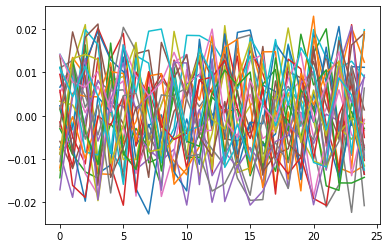

In [55]:
weights = model.get_weights()
weights = np.array(weights)
print(weights.shape)
print(weights[0][0].shape)
plt.plot(weights[0][0])

In [ ]:
pd.DataFrame(history.history).loc[:,['loss','val_loss']].plot(figsize=(8,5))
plt.grid(True)

In [ ]:
# 예측하기
pred_y = model.predict(after_sliding_X)
if TD_Boolean == 0:
    pred_y = pred_y.reshape(pred_y.shape[0],1,pred_y.shape[1])
elif TD_Boolean == 1:
    plt.plot(pred_y[1,:,:])
    plt.show()

print(pred_y[1,:,:])

# Visualization

In [ ]:
# 그래프 Label용 문자열 데이터 생성
column_list = data_train.columns.tolist()
y_column_actual = []
y_column_pred = []
for s in column_list:
  if 'DISP' in s:
    y_column_actual.append(s)
for i in range(len(y_column_actual)):
  y_column_pred.append(y_column_actual[i] + '_Prediction')

## Partial_Pred 함수 정의

In [ ]:
## Pred_y의 특정 Batch들만 합쳐서 특정 구간에 대한 Pred_y 생성
def partial_pred(input_array,segment=10):
    total_xlength = segment*input_array.shape[1]
    total_ylength = input_array.shape[2]
    pred_y_partial = np.zeros(( total_xlength,total_ylength ))
    for i in range(segment):
        if i == 0:
            pred_y_partial = input_array[i,:,:]
        else:
            pred_y_partial = np.concatenate((pred_y_partial,input_array[i,:,:]),axis = 0)
    return pred_y_partial

## Total_Pred

In [ ]:
## Pred_y Batch 들을 합쳐서 전 구간에 대한 pred_y 생성
def total_pred(input_array):
    total_xlength = input_array.shape[0]*input_array.shape[1]
    total_ylength = input_array.shape[2]
    pred_y_total = np.zeros(( total_xlength,total_ylength ))
    for i in range(input_array.shape[0]):
        if i == 0:
            pred_y_total = input_array[i,:,:]
        else:
            pred_y_total = np.concatenate((pred_y_total,input_array[i,:,:]),axis = 0)
    return pred_y_total

In [ ]:
#Scaler Inverse Transform
segment = 20
pred_y_total = total_pred(pred_y)
pred_y_partial = partial_pred(pred_y,segment)
if Scale_Boolean == 1:
    pred_y_total = Y_Scaler.inverse_transform(pred_y_total)
    pred_y_partial = Y_Scaler.inverse_transform(pred_y_partial)
    pd_raw_Y = Y_Scaler.inverse_transform(pd_raw_Y)
    pd_raw_Y2 = Y2_Scaler.inverse_transform(pd_raw_Y2)
    pd_raw_Y3 = Y_Scaler.inverse_transform(pd_raw_Y3)

## Plotting

In [ ]:
## 특정 구간에 대한 Pred_y 시각화
plt.figure(figsize = (30,10))
Colors = ['black','grey','salmon','red','greenyellow','olivedrab','yellow','gold','navy','cornflowerblue']

for i in range(len(y_column_actual)-1):
    
    if Scale_Boolean == 0:
        plt.plot(pd_raw_Y.iloc[time_lag:time_lag+segment*n_steps,i], label=y_column_actual[i], color = Colors[2*i])
    elif Scale_Boolean == 1:
        plt.plot(pd_raw_Y[time_lag:time_lag+segment*n_steps,i], label=y_column_actual[i], color = Colors[2*i])
    if TD_Boolean == 0:
        for k in range(segment):
            plt.scatter(n_steps*(k+1), pred_y_partial[k,i], color = Colors[2*i+1], s = 100)
    elif TD_Boolean == 1:
        plt.plot(pred_y_partial[:segment*n_steps,i], label=y_column_pred[i], color = Colors[2*i+1])
    for j in range(segment+1):
        plt.axvline(j*n_steps, color='black', linewidth=1)
    plt.legend( bbox_to_anchor=(1.0, 1.0) )
plt.show()

In [ ]:
plt.figure(figsize = (30,10))
Colors = ['black','grey','salmon','red','greenyellow','olivedrab','yellow','gold','navy','cornflowerblue']

for i in range(len(y_column_actual)-1):
    
    if Scale_Boolean == 0:
        plt.plot(pd_raw_Y.iloc[time_lag:,i], label=y_column_actual[i], color = Colors[2*i])
    elif Scale_Boolean == 1:
        plt.plot(pd_raw_Y[time_lag:,i], label=y_column_actual[i], color = Colors[2*i])
    if TD_Boolean == 0:
        for k in range(pred_y.shape[0]):
            plt.scatter(n_steps*(k+1), pred_y_total[k,i], color = Colors[2*i+1], s = 50)
    elif TD_Boolean == 1:
        plt.plot(pred_y_total[:,i], label=y_column_pred[i], color = Colors[2*i+1])
    plt.legend( bbox_to_anchor=(1.0, 1.0) )
plt.show()

In [ ]:
i = len(y_column_actual)-1
    
if Scale_Boolean == 0:
    plt.plot(pd_raw_Y.iloc[time_lag:,i], label=y_column_actual[i], color = Colors[2*i])
elif Scale_Boolean == 1:
    plt.plot(pd_raw_Y[time_lag:,i], label=y_column_actual[i], color = Colors[2*i])
if TD_Boolean == 0:
    for k in range(pred_y.shape[0]):
        plt.scatter(n_steps*(k+1), pred_y_total[k,i], color = Colors[2*i+1], s = 50)
elif TD_Boolean == 1:
    plt.plot(pred_y_total[:,i], label=y_column_pred[i], color = Colors[2*i+1])
plt.legend( bbox_to_anchor=(1.0, 1.0) )
plt.show()

# n_step, time ,stride에 따른 Model

In [275]:
def sliding_window(X, Y, n_steps, time, stride = 1, time_distributed = 0):
        
    # 1. X, Y time delta에 따라 나누기
    if time > 0:
        X = X[:-time]
        Y = Y[time:]
    elif time == 0:
        pass
    
    # 2. 결과로 낼 x, y
    result_X = np.array([X[0:n_steps].values])
    
    if time_distributed == 1:
        result_Y = np.array([Y[0:n_steps].values])
    else: 
        result_Y = np.array([Y[n_steps:n_steps+1].values])

    # 3. step과 stride에 맞춰서 concat, time_distributed 값에 따라 다르게 Y 만들기
    
    if time_distributed == 1:
        
        for i in tqdm(range(1, X.shape[0]),total=round(((len(X)-(n_steps-1)-1)/stride))): # revise
            if i * stride + n_steps > X.shape[0]:
                print("Data set finish") # add
                break
            result_X = np.concatenate((result_X, [X[i*stride: i*stride+n_steps].values]))
            result_Y = np.concatenate((result_Y, [Y[i*stride: i*stride+n_steps].values]))
            
    else:
        for i in tqdm(range(1, X.shape[0]),total=round(((len(X)-(n_steps-1)-1)/stride))): # revise
            if i * stride + n_steps > X.shape[0]:
                print("Data set finish") # add
                break
            result_X = np.concatenate((result_X, [X[i*stride: i*stride+n_steps].values]))
            result_Y = np.concatenate((result_Y, [Y[i*stride+n_steps: i*stride+n_steps+1].values]))
    return result_X, result_Y

In [276]:
 def create_model(kernel_size,strides, TD_Boolean,padding):
        kernel_size = kernel_size
        if TD_Boolean == 1: # time distributed를 사용하려면 무조건 padding="same", strides=1
            strides = 1
            padding = "same"
        else:
            strides = strides
        input_length = pd_raw_X.shape[1]

        model = keras.models.Sequential()
        if Cv_Boolean == 1:
            model.add( keras.layers.Conv1D(filters = 30, kernel_size = kernel_size, strides = strides, padding = padding, input_shape=[None,input_length]) )
            model.add( keras.layers.GRU(64, return_sequences = True, kernel_regularizer=keras.regularizers.l2(0.001)) ) 
            model.add( keras.layers.Dropout(0.5) )
            model.add( keras.layers.LayerNormalization() )
        elif Cv_Boolean == 0:
            model.add( keras.layers.GRU(64, return_sequences = True, kernel_regularizer=keras.regularizers.l2(0.001), input_shape=[None,input_length]) )
            model.add( keras.layers.Dropout(0.5) )
            model.add( keras.layers.LayerNormalization() )


        model.add( keras.layers.GRU(64, return_sequences = True, kernel_regularizer=keras.regularizers.l2(0.001)) )
        model.add( keras.layers.Dropout(0.5) )
        model.add( keras.layers.LayerNormalization() )
#        model.add( keras.layers.GRU(64, return_sequences = True, kernel_regularizer=keras.regularizers.l2(0.001)) )
#        model.add( keras.layers.Dropout(0.5) )
#        model.add( keras.layers.LayerNormalization() )
#        model.add( keras.layers.GRU(64, return_sequences = True, kernel_regularizer=keras.regularizers.l2(0.001)) )
#        model.add( keras.layers.Dropout(0.5) )
#        model.add( keras.layers.LayerNormalization() )

        if TD_Boolean == 1:
            model.add( keras.layers.GRU(32, return_sequences = True) )
            model.add( keras.layers.TimeDistributed(keras.layers.Dense(pd_raw_Y.shape[1],kernel_regularizer=keras.regularizers.l2(0.001))))
        else:
            model.add( keras.layers.GRU(32, return_sequences = False) )
            model.add( keras.layers.Dense(pd_raw_Y.shape[1],kernel_regularizer=keras.regularizers.l2(0.001)) )
        #plot_model(model)
        model.compile(loss="mse", optimizer="adam")
        return model

In [279]:
# Condition
n_steps = [60,300,600,1800,3600] # 1분, 5분, 10분, 30분, 1시간
time_lag = [1,5,10]
strides = [60,300,600,1800,3600]
TD_Boolean = 1

In [281]:
history_list = []
for i in n_steps:
    for j in time_lag:
        for k in strides:
            if k<=i: # stride가 n_step보다 크면 손실되는 데이터가 발생
                print("n_step:",i,"time_lag:",j,"stride",k)
                after_sliding_X,after_sliding_Y = sliding_window(X=pd_raw_X, Y=pd_raw_Y, 
                                                                 n_steps=i, time=j, stride=k, time_distributed=TD_Boolean)
                after_sliding_X_V, after_sliding_X_T, after_sliding_Y_V, after_sliding_Y_T =train_test_split(after_sliding_X, after_sliding_Y, 
                                                                                                             test_size=0.5, random_state=11, shuffle=True)
                print("Model fitting start")
                model = create_model(kernel_size=int(i/5),strides=int(i/10),TD_Boolean=TD_Boolean,padding="valid")
                history = model.fit(after_sliding_X_T, after_sliding_Y_T,
                                    epochs=5, validation_data=(after_sliding_X_V, after_sliding_Y_V), 
                                    callbacks=[es_callback,model_checkpoint_callback],verbose=0)
                history_list.append(history.history) # 각 condition별 loss값 저장
                print("Model Loss:",history.history,"\n")
            else:
                pass

n_step: 60 time_lag: 1 stride 60


100%|███████████████████████████████████████████████████████████████████████████████| 949/949 [00:01<00:00, 785.65it/s]


Data set finish
Model fitting start
Model Loss: {'loss': [0.5618751645088196, 0.31099724769592285, 0.2531580924987793, 0.21636050939559937, 0.190144881606102], 'val_loss': [0.3886570334434509, 0.35748785734176636, 0.28903454542160034, 0.27680522203445435, 0.24326501786708832]} 

n_step: 60 time_lag: 5 stride 60


100%|██████████████████████████████████████████████████████████████████████████████▉| 948/949 [00:01<00:00, 806.18it/s]


Data set finish
Model fitting start
Model Loss: {'loss': [0.689561128616333, 0.35455238819122314, 0.27038446068763733, 0.23016564548015594, 0.2013518363237381], 'val_loss': [0.5625530481338501, 0.40981510281562805, 0.301871120929718, 0.2610209584236145, 0.247121661901474]} 

n_step: 60 time_lag: 10 stride 60


100%|██████████████████████████████████████████████████████████████████████████████▉| 948/949 [00:01<00:00, 790.89it/s]


Data set finish
Model fitting start
Model Loss: {'loss': [0.6417715549468994, 0.35595303773880005, 0.27441808581352234, 0.2274642139673233, 0.2004726678133011], 'val_loss': [0.43208587169647217, 0.3000258803367615, 0.28390106558799744, 0.2655964493751526, 0.2438240647315979]} 

n_step: 300 time_lag: 1 stride 60


100%|███████████████████████████████████████████████████████████████████████████████| 945/945 [00:05<00:00, 169.72it/s]


Data set finish
Model fitting start
Model Loss: {'loss': [0.6488997936248779, 0.3429222106933594, 0.24827876687049866, 0.20589517056941986, 0.1784089058637619], 'val_loss': [0.3956693708896637, 0.2839639484882355, 0.24355871975421906, 0.2078772634267807, 0.19317792356014252]} 

n_step: 300 time_lag: 1 stride 300


100%|███████████████████████████████████████████████████████████████████████████████| 189/189 [00:00<00:00, 776.66it/s]


Data set finish
Model fitting start
Model Loss: {'loss': [1.1544963121414185, 0.646061360836029, 0.5493861436843872, 0.4668689966201782, 0.4193843603134155], 'val_loss': [0.7584536671638489, 0.7643992304801941, 0.5904561877250671, 0.45749008655548096, 0.39934679865837097]} 

n_step: 300 time_lag: 5 stride 60


100%|██████████████████████████████████████████████████████████████████████████████▉| 944/945 [00:05<00:00, 169.89it/s]


Data set finish
Model fitting start
Model Loss: {'loss': [0.6375993490219116, 0.33959490060806274, 0.2541869878768921, 0.20608192682266235, 0.17668144404888153], 'val_loss': [0.42609715461730957, 0.31830909848213196, 0.26924166083335876, 0.2356066256761551, 0.22297491133213043]} 

n_step: 300 time_lag: 5 stride 300


 99%|██████████████████████████████████████████████████████████████████████████████▌| 188/189 [00:00<00:00, 769.38it/s]


Data set finish
Model fitting start
Model Loss: {'loss': [1.006592869758606, 0.6324073672294617, 0.5382532477378845, 0.46103140711784363, 0.39272305369377136], 'val_loss': [0.6956217288970947, 0.7221477031707764, 0.6111742258071899, 0.4959259331226349, 0.41203007102012634]} 

n_step: 300 time_lag: 10 stride 60


100%|██████████████████████████████████████████████████████████████████████████████▉| 944/945 [00:05<00:00, 170.95it/s]


Data set finish
Model fitting start
Model Loss: {'loss': [0.6489694118499756, 0.33730727434158325, 0.24480678141117096, 0.20213380455970764, 0.17557775974273682], 'val_loss': [0.3827441930770874, 0.2438148707151413, 0.21631042659282684, 0.19959977269172668, 0.1841515302658081]} 

n_step: 300 time_lag: 10 stride 300


 99%|██████████████████████████████████████████████████████████████████████████████▌| 188/189 [00:00<00:00, 791.91it/s]


Data set finish
Model fitting start
Model Loss: {'loss': [1.1132045984268188, 0.6403605937957764, 0.5551647543907166, 0.4856347441673279, 0.429191917181015], 'val_loss': [0.6442857384681702, 0.6385059952735901, 0.6494543552398682, 0.5818853974342346, 0.4576095938682556]} 

n_step: 600 time_lag: 1 stride 60


100%|████████████████████████████████████████████████████████████████████████████████| 940/940 [00:11<00:00, 83.91it/s]


Data set finish
Model fitting start
Model Loss: {'loss': [0.6202747821807861, 0.31475192308425903, 0.2363804429769516, 0.1948910504579544, 0.16813363134860992], 'val_loss': [0.3536384403705597, 0.2594180107116699, 0.20804817974567413, 0.19626842439174652, 0.1775231808423996]} 

n_step: 600 time_lag: 1 stride 300


100%|███████████████████████████████████████████████████████████████████████████████| 188/188 [00:00<00:00, 371.67it/s]


Data set finish
Model fitting start
Model Loss: {'loss': [0.8822222948074341, 0.5736477375030518, 0.47748395800590515, 0.4177412688732147, 0.3740072250366211], 'val_loss': [0.6146506071090698, 0.5425590872764587, 0.5075878500938416, 0.4213199317455292, 0.3729175925254822]} 

n_step: 600 time_lag: 1 stride 600


100%|█████████████████████████████████████████████████████████████████████████████████| 94/94 [00:00<00:00, 713.88it/s]

Data set finish
Model fitting start


Model Loss: {'loss': [1.1012810468673706, 0.6683788299560547, 0.5895434021949768, 0.5034886002540588, 0.455546110868454], 'val_loss': [0.6879835724830627, 0.6428093314170837, 0.5738661885261536, 0.5361913442611694, 0.4799974262714386]} 

n_step: 600 time_lag: 5 stride 60


100%|███████████████████████████████████████████████████████████████████████████████▉| 939/940 [00:10<00:00, 86.35it/s]


Data set finish
Model fitting start
Model Loss: {'loss': [0.57418292760849, 0.30772536993026733, 0.23187929391860962, 0.19308160245418549, 0.1659587174654007], 'val_loss': [0.3427465260028839, 0.28556716442108154, 0.24865898489952087, 0.2257242500782013, 0.20169319212436676]} 

n_step: 600 time_lag: 5 stride 300


 99%|██████████████████████████████████████████████████████████████████████████████▌| 187/188 [00:00<00:00, 404.06it/s]


Data set finish
Model fitting start
Model Loss: {'loss': [1.1930766105651855, 0.6994140148162842, 0.5754504799842834, 0.5017372965812683, 0.452662855386734], 'val_loss': [0.827824056148529, 0.7175885438919067, 0.6201068162918091, 0.5512744188308716, 0.47496193647384644]} 

n_step: 600 time_lag: 5 stride 600


 99%|████████████████████████████████████████████████████████████████████████████████▏| 93/94 [00:00<00:00, 745.80it/s]

Data set finish
Model fitting start


Model Loss: {'loss': [1.0578137636184692, 0.7036231756210327, 0.6328868269920349, 0.5648829936981201, 0.5110651254653931], 'val_loss': [0.9117382168769836, 0.8306657671928406, 0.764873743057251, 0.662849485874176, 0.5832861065864563]} 

n_step: 600 time_lag: 10 stride 60


100%|███████████████████████████████████████████████████████████████████████████████▉| 939/940 [00:10<00:00, 86.69it/s]


Data set finish
Model fitting start
Model Loss: {'loss': [0.5985777378082275, 0.2991696298122406, 0.2271457463502884, 0.19055451452732086, 0.16618269681930542], 'val_loss': [0.34942322969436646, 0.2645798623561859, 0.23438958823680878, 0.20537729561328888, 0.18385671079158783]} 

n_step: 600 time_lag: 10 stride 300


 99%|██████████████████████████████████████████████████████████████████████████████▌| 187/188 [00:00<00:00, 411.18it/s]


Data set finish
Model fitting start
Model Loss: {'loss': [0.9294232130050659, 0.5641636252403259, 0.48733511567115784, 0.42862027883529663, 0.384585440158844], 'val_loss': [0.7212120294570923, 0.5688957571983337, 0.4610024690628052, 0.38748133182525635, 0.3636939823627472]} 

n_step: 600 time_lag: 10 stride 600


 99%|████████████████████████████████████████████████████████████████████████████████▏| 93/94 [00:00<00:00, 770.63it/s]

Data set finish
Model fitting start


Model Loss: {'loss': [1.467331886291504, 0.8263052105903625, 0.6666894555091858, 0.5840018391609192, 0.5348796248435974], 'val_loss': [0.761680006980896, 0.5918968915939331, 0.6188567876815796, 0.6514090895652771, 0.6455866098403931]} 

n_step: 1800 time_lag: 1 stride 60


100%|████████████████████████████████████████████████████████████████████████████████| 920/920 [00:30<00:00, 29.77it/s]


Data set finish
Model fitting start
Model Loss: {'loss': [0.5983169078826904, 0.32005932927131653, 0.24064767360687256, 0.19982855021953583, 0.17180828750133514], 'val_loss': [0.45857158303260803, 0.33670035004615784, 0.26349982619285583, 0.24774062633514404, 0.2206040322780609]} 

n_step: 1800 time_lag: 1 stride 300


100%|███████████████████████████████████████████████████████████████████████████████| 184/184 [00:01<00:00, 120.31it/s]


Data set finish
Model fitting start
Model Loss: {'loss': [1.2299156188964844, 0.7128783464431763, 0.566325306892395, 0.5021200776100159, 0.45184972882270813], 'val_loss': [0.7176469564437866, 0.5233891606330872, 0.5362305641174316, 0.5213704109191895, 0.45274466276168823]} 

n_step: 1800 time_lag: 1 stride 600


100%|█████████████████████████████████████████████████████████████████████████████████| 92/92 [00:00<00:00, 274.51it/s]

Data set finish
Model fitting start


Model Loss: {'loss': [1.3329706192016602, 0.7950609922409058, 0.6838578581809998, 0.588472306728363, 0.5336948037147522], 'val_loss': [0.7176309823989868, 0.6824451088905334, 0.6621031761169434, 0.6833502054214478, 0.6653218865394592]} 

n_step: 1800 time_lag: 1 stride 1800


 97%|██████████████████████████████████████████████████████████████████████████████▍  | 30/31 [00:00<00:00, 716.23it/s]

Data set finish
Model fitting start


Model Loss: {'loss': [1.2751929759979248, 0.9350919127464294, 0.7898551821708679, 0.6942625045776367, 0.6338401436805725], 'val_loss': [1.1737251281738281, 0.9938791394233704, 0.8897583484649658, 0.8251552581787109, 0.7473313212394714]} 

n_step: 1800 time_lag: 5 stride 60


100%|███████████████████████████████████████████████████████████████████████████████▉| 919/920 [00:31<00:00, 29.04it/s]


Data set finish
Model fitting start
Model Loss: {'loss': [0.600334644317627, 0.316641628742218, 0.24428312480449677, 0.20238694548606873, 0.17249253392219543], 'val_loss': [0.4692273736000061, 0.3368687629699707, 0.2935870885848999, 0.27197885513305664, 0.2551339268684387]} 

n_step: 1800 time_lag: 5 stride 300


 99%|██████████████████████████████████████████████████████████████████████████████▌| 183/184 [00:01<00:00, 103.01it/s]


Data set finish
Model fitting start
Model Loss: {'loss': [1.2433732748031616, 0.6929012537002563, 0.5774224996566772, 0.4993026554584503, 0.45349088311195374], 'val_loss': [0.7106770873069763, 0.678288996219635, 0.62250816822052, 0.5744785070419312, 0.5392318964004517]} 

n_step: 1800 time_lag: 5 stride 600


 99%|████████████████████████████████████████████████████████████████████████████████ | 91/92 [00:00<00:00, 294.30it/s]

Data set finish
Model fitting start


Model Loss: {'loss': [1.4811896085739136, 0.9374343752861023, 0.791949450969696, 0.6897597908973694, 0.6168694496154785], 'val_loss': [0.9522408246994019, 0.6428103446960449, 0.6057521104812622, 0.5684264898300171, 0.5609476566314697]} 

n_step: 1800 time_lag: 5 stride 1800


 97%|██████████████████████████████████████████████████████████████████████████████▍  | 30/31 [00:00<00:00, 589.80it/s]

Data set finish
Model fitting start


Model Loss: {'loss': [1.4263523817062378, 0.8894785642623901, 0.7145934104919434, 0.6640756726264954, 0.6494143009185791], 'val_loss': [1.3374179601669312, 0.9342465996742249, 0.7257802486419678, 0.63436359167099, 0.6083769202232361]} 

n_step: 1800 time_lag: 10 stride 60


100%|███████████████████████████████████████████████████████████████████████████████▉| 919/920 [00:31<00:00, 29.24it/s]


Data set finish
Model fitting start
Model Loss: {'loss': [0.6828442811965942, 0.35434794425964355, 0.2582598626613617, 0.21150422096252441, 0.18049591779708862], 'val_loss': [0.5194201469421387, 0.28114578127861023, 0.23227061331272125, 0.20820513367652893, 0.19111226499080658]} 

n_step: 1800 time_lag: 10 stride 300


 99%|██████████████████████████████████████████████████████████████████████████████▌| 183/184 [00:01<00:00, 106.55it/s]


Data set finish
Model fitting start
Model Loss: {'loss': [0.9108262062072754, 0.6317334175109863, 0.5471935868263245, 0.4689710736274719, 0.41595736145973206], 'val_loss': [0.6967819929122925, 0.7231553196907043, 0.5552348494529724, 0.4395699203014374, 0.4078177511692047]} 

n_step: 1800 time_lag: 10 stride 600


 99%|████████████████████████████████████████████████████████████████████████████████ | 91/92 [00:00<00:00, 283.36it/s]

Data set finish
Model fitting start


Model Loss: {'loss': [1.2670727968215942, 0.761486291885376, 0.6278000473976135, 0.5586647987365723, 0.5008453130722046], 'val_loss': [0.9095506072044373, 0.5020710825920105, 0.4528665840625763, 0.5835365653038025, 0.6322414875030518]} 

n_step: 1800 time_lag: 10 stride 1800


 97%|██████████████████████████████████████████████████████████████████████████████▍  | 30/31 [00:00<00:00, 613.88it/s]

Data set finish
Model fitting start


Model Loss: {'loss': [1.3176405429840088, 0.8132317066192627, 0.632153332233429, 0.5128253698348999, 0.45260486006736755], 'val_loss': [0.7492790222167969, 0.6219528317451477, 0.6334890723228455, 0.6644591689109802, 0.681876540184021]} 

n_step: 3600 time_lag: 1 stride 60


100%|████████████████████████████████████████████████████████████████████████████████| 890/890 [01:00<00:00, 14.73it/s]


Data set finish
Model fitting start
Model Loss: {'loss': [0.6868727207183838, 0.3816450238227844, 0.2817522883415222, 0.22500190138816833, 0.19084906578063965], 'val_loss': [0.516486644744873, 0.381438672542572, 0.27950069308280945, 0.23685534298419952, 0.21572338044643402]} 

n_step: 3600 time_lag: 1 stride 300


100%|████████████████████████████████████████████████████████████████████████████████| 178/178 [00:02<00:00, 61.71it/s]


Data set finish
Model fitting start
Model Loss: {'loss': [1.352362871170044, 0.7763127088546753, 0.6326305866241455, 0.535112738609314, 0.47695156931877136], 'val_loss': [0.8782460689544678, 0.5768067240715027, 0.5558150410652161, 0.5183447003364563, 0.5074263215065002]} 

n_step: 3600 time_lag: 1 stride 600


100%|█████████████████████████████████████████████████████████████████████████████████| 89/89 [00:00<00:00, 142.77it/s]


Data set finish
Model fitting start
Model Loss: {'loss': [1.5646395683288574, 0.8926600217819214, 0.7869430780410767, 0.700079619884491, 0.6214127540588379], 'val_loss': [0.7139838337898254, 0.6888227462768555, 0.6812781691551208, 0.645675778388977, 0.6203873753547668]} 

n_step: 3600 time_lag: 1 stride 1800


 97%|██████████████████████████████████████████████████████████████████████████████▎  | 29/30 [00:00<00:00, 372.94it/s]

Data set finish
Model fitting start


Model Loss: {'loss': [1.3469244241714478, 0.8596924543380737, 0.709618330001831, 0.6030022501945496, 0.5681332945823669], 'val_loss': [0.8329401016235352, 0.7427374124526978, 0.6270514726638794, 0.6651725172996521, 0.7243263125419617]} 

n_step: 3600 time_lag: 1 stride 3600


 93%|███████████████████████████████████████████████████████████████████████████▌     | 14/15 [00:00<00:00, 519.88it/s]

Data set finish
Model fitting start


Model Loss: {'loss': [1.741237998008728, 1.126920461654663, 0.9147241711616516, 0.7838572859764099, 0.6942933797836304], 'val_loss': [1.7091490030288696, 1.4322699308395386, 1.301067590713501, 1.2179569005966187, 1.1723023653030396]} 

n_step: 3600 time_lag: 5 stride 60


100%|███████████████████████████████████████████████████████████████████████████████▉| 889/890 [01:01<00:00, 14.39it/s]


Data set finish
Model fitting start
Model Loss: {'loss': [0.6773660778999329, 0.3727845847606659, 0.26932159066200256, 0.21180249750614166, 0.1805567741394043], 'val_loss': [0.5329806804656982, 0.3607026934623718, 0.29474398493766785, 0.24676236510276794, 0.22779907286167145]} 

n_step: 3600 time_lag: 5 stride 300


 99%|███████████████████████████████████████████████████████████████████████████████▌| 177/178 [00:02<00:00, 68.59it/s]


Data set finish
Model fitting start
Model Loss: {'loss': [1.049683928489685, 0.653533399105072, 0.5755916833877563, 0.49609196186065674, 0.43216198682785034], 'val_loss': [0.7317849397659302, 0.682237446308136, 0.5962156057357788, 0.48133334517478943, 0.4238066077232361]} 

n_step: 3600 time_lag: 5 stride 600


 99%|████████████████████████████████████████████████████████████████████████████████ | 88/89 [00:00<00:00, 132.66it/s]


Data set finish
Model fitting start
Model Loss: {'loss': [1.2095361948013306, 0.8981130719184875, 0.7386423945426941, 0.6624994277954102, 0.6020441055297852], 'val_loss': [1.1755619049072266, 0.8910310864448547, 0.7840709090232849, 0.7554155588150024, 0.7026596665382385]} 

n_step: 3600 time_lag: 5 stride 1800


 97%|██████████████████████████████████████████████████████████████████████████████▎  | 29/30 [00:00<00:00, 346.05it/s]

Data set finish
Model fitting start


Model Loss: {'loss': [1.8429635763168335, 0.8755045533180237, 0.7795814275741577, 0.7116881012916565, 0.6479248404502869], 'val_loss': [0.9884186387062073, 0.8617525100708008, 0.7756142020225525, 0.6691898703575134, 0.6038965582847595]} 

n_step: 3600 time_lag: 5 stride 3600


 93%|███████████████████████████████████████████████████████████████████████████▌     | 14/15 [00:00<00:00, 585.04it/s]

Data set finish
Model fitting start


Model Loss: {'loss': [1.7030256986618042, 0.8211143016815186, 0.6843931674957275, 0.6437196731567383, 0.5787286162376404], 'val_loss': [1.109975814819336, 1.0870856046676636, 1.108184576034546, 1.127768635749817, 1.1927993297576904]} 

n_step: 3600 time_lag: 10 stride 60


100%|███████████████████████████████████████████████████████████████████████████████▉| 889/890 [01:03<00:00, 14.01it/s]


Data set finish
Model fitting start
Model Loss: {'loss': [0.6531034708023071, 0.3777223825454712, 0.2743915319442749, 0.22249355912208557, 0.18673720955848694], 'val_loss': [0.5900394320487976, 0.3685615658760071, 0.30826422572135925, 0.2913358211517334, 0.24623817205429077]} 

n_step: 3600 time_lag: 10 stride 300


 99%|███████████████████████████████████████████████████████████████████████████████▌| 177/178 [00:02<00:00, 62.78it/s]


Data set finish
Model fitting start
Model Loss: {'loss': [1.1215381622314453, 0.7477138638496399, 0.6288479566574097, 0.5530377626419067, 0.4877277612686157], 'val_loss': [0.7622615694999695, 0.7122032642364502, 0.6227878332138062, 0.48198220133781433, 0.45391619205474854]} 

n_step: 3600 time_lag: 10 stride 600


 99%|████████████████████████████████████████████████████████████████████████████████ | 88/89 [00:00<00:00, 145.72it/s]


Data set finish
Model fitting start
Model Loss: {'loss': [1.3251808881759644, 0.7712199687957764, 0.6541802287101746, 0.5848486423492432, 0.5314995050430298], 'val_loss': [0.758257269859314, 0.6351713538169861, 0.6199346780776978, 0.6154143810272217, 0.5994829535484314]} 

n_step: 3600 time_lag: 10 stride 1800


 97%|██████████████████████████████████████████████████████████████████████████████▎  | 29/30 [00:00<00:00, 354.48it/s]

Data set finish
Model fitting start


Model Loss: {'loss': [1.2863070964813232, 0.7813943028450012, 0.68170565366745, 0.6140630841255188, 0.5615645051002502], 'val_loss': [0.8885753154754639, 0.7478173971176147, 0.6670310497283936, 0.6186354756355286, 0.5948798656463623]} 

n_step: 3600 time_lag: 10 stride 3600


 93%|███████████████████████████████████████████████████████████████████████████▌     | 14/15 [00:00<00:00, 584.92it/s]

Data set finish
Model fitting start


Model Loss: {'loss': [1.6273590326309204, 1.3858805894851685, 1.0670640468597412, 0.8805120587348938, 0.7750029563903809], 'val_loss': [1.6802819967269897, 1.4286612272262573, 1.3616962432861328, 1.427672028541565, 1.538130521774292]} 

